## PRiAD 4 - Improved

# Uczenie nienadzorowane

Tematem labolatorium jest uczenie nienadzorowane - rodzaj uczenia maszynowego które polega na odkrywaniu w zbiorze danych wzorów przy minimalnej ingerencji człowieka. Zostaną pokazane 2 metody grupowania: grupowanie hierarchiczne aglomeracyjne oraz metoda k-średnich. Ponadto na przykładzie koszyka zakupowego zostanie zaprezentowany algorytm Apriori, który pozwala na znajdowanie korelacji pomiędzy przedmiotami.

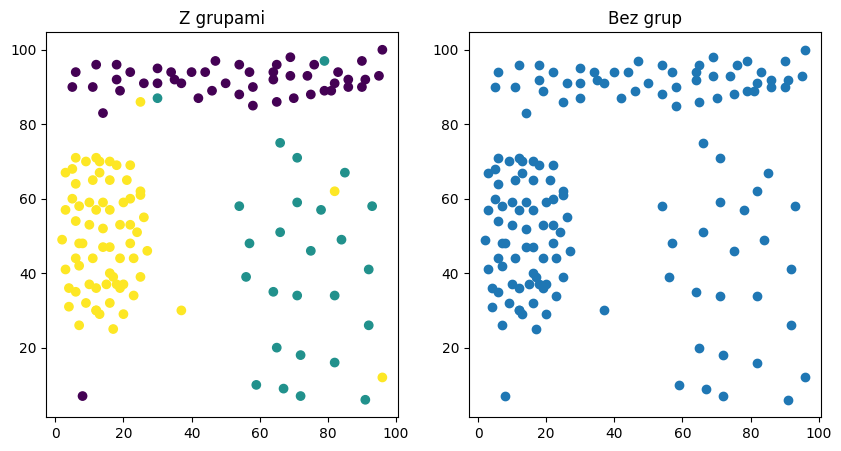

<Figure size 640x480 with 0 Axes>

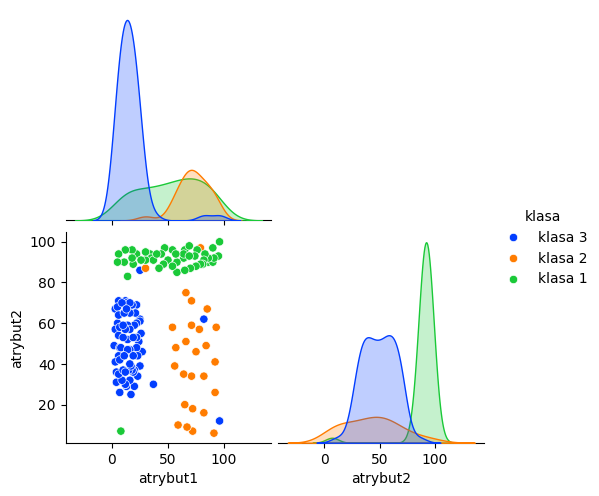

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import danych
def mk_dataframes(file_name):
    data_og = pd.read_csv(file_name)
    data_noclass = data_og.iloc[:,:-1]
    # usunięcie ostatniej kolumny z grupami

    #data_noclass = data_og.drop(columns=["klasa"])
    # usunięcie ostatniej kolumny z datami za pomocą nazwy kolumny

    return (data_og, data_noclass)
# można zmienić zestaw danych na inny z podanych danych testowych, aby zobaczyć jak poszczególne metody różnią się między sobą

data_og, data_noclass = mk_dataframes("dane6.csv")


# pokazanie początku danych
#print(data_og.head())
#print(data_noclass.head())
plt.figure(figsize=(10, 5))

# wykres z grupami
plt.subplot(1,2,1)
plt.title("Z grupami")
plt.scatter(x = data_og["atrybut1"], y = data_og["atrybut2"], c=data_og['klasa'].astype('category').cat.codes)
# metody użyte przy opisie grup: astype('category') - konwersja kolumny na typ 'category', cat - kolejna konwersja na typ, który pozwala na użycie metody codes, codes - zwraca tablicę z wartościami numerycznymi, które odpowiadają poszczególnym klasom
# w uproszczeniu te trzy metody konwertują kolumnę na typy liczbowe odpowiadające poszczególnym grupom
# metody te można pominąć, jeżeli grupy są zapisane w formacie liczbowym

# wykres bez grup
plt.subplot(1,2,2)
plt.title("Bez grup")
plt.scatter(x = data_noclass["atrybut1"], y = data_noclass["atrybut2"])

plt.figure()
sns.pairplot(data_og, hue = 'klasa', kind = 'scatter', palette = 'bright', corner=True)
#atrybut corner=True usuwa górną połowę wykresu, ponieważ jest to odbicie lustrzane dolnej połowy, a skraca czas wykonania o połowę

# 1. Hierarchiczne grupowanie aglomeracyjne

Jedną z najważniejszych metod uczenia nienadzorowanego jest grupowanie danych. Metody dające podobne rezultaty znajdują się równierz w panteonie uczenia nadzorowanego, jednakże wymagają one znania wcześniej grup przynajmniej części obiektów. Do grupowania wykorzystuje się prawdopodobieństwo które jest wyliczane przy użyciu:
+ metryk odległości między klastrami, takich jak Euklidesowa, miejska (znana również jako Manhattana), Czebyszewa, Mińkowskiego, Canberra
+ metod wyboru punktów które reprezentują dane klastry, takie jak Warda, najdalszego i najbliższego sąsiedztwa, średniej grupowej, mediany oraz środka ciężkości.

[Źródło](https://pl.wikipedia.org/wiki/Klastrowanie_hierarchiczne)

**Grupowanie Hierarchiczne** polaga na łączeniu obiektów w klastry, czyli grupy, które są do siebie najbardziej podobne według powyższych metod i metryk. Grupowanie można przedstawić na dendogramie, czyli diagramie przedstawiającym połączenia w postaci drzewa. Są dwa podejścia do budowania hierarchii grup:
+ Aglomeracyjne - początkowo każdy obiekt jest oddzielnym klastrem,  któ©e następnie są łączone
+ Rozdzielające (podziałowe) - początkowo wszystkie obiekty należą do jednego klastru, a następnie są dzielone na mniejsze skupiska

W tym ćwiczeniu pokazana będzie metoda aglomeracyjna

Poniżej pokazane są różne wyniki grupowań, dla różnych kombinacji metod i metryk

Opisy metod:
+ average - średnie odległości pomiędzy grupami
+ complete - maksymalne odległości pomiędzy grupami
+ single - minimalne odległości pomiędzy grupami
+ ward - minimalne wariancje między łączonymi grupami

Opisy metryk:
+ Euklidesowa - Najprostsza miara, odległość w linii prostej
+ Miejska/Manhattan - Suma linni prostych prostopadłych do osi x i y łączącej punkty
+ Czybyszewa - Maksymalna różnica pomiędzy warościami punktów
+ Mińkowskiego - Suma kwadratów różnic współrzędnych
+ Canberra - Suma względnych błędów absolutnych pomiędzy wartościami

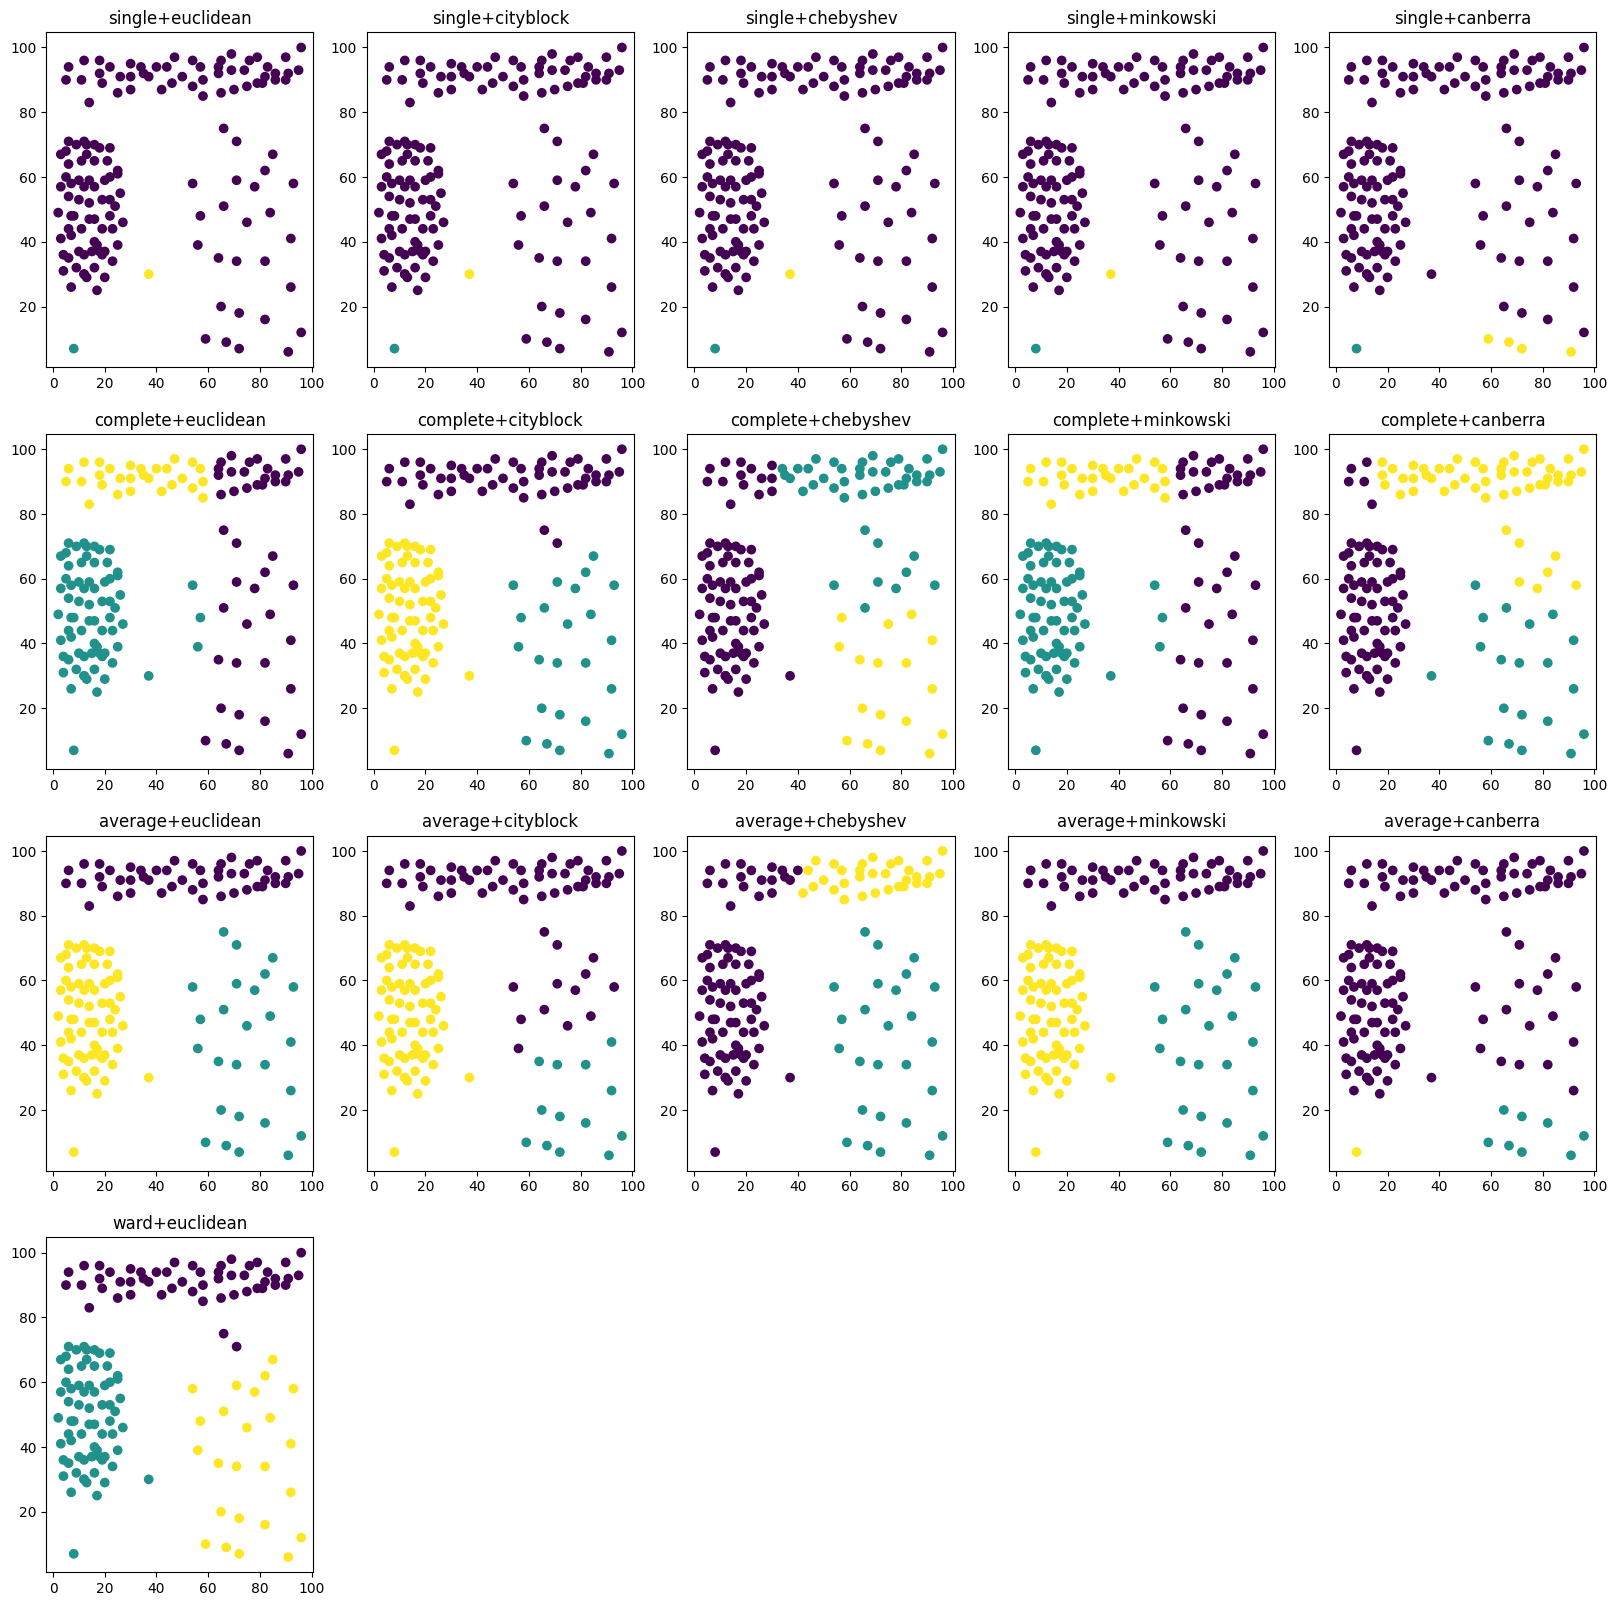

In [34]:
from sklearn.cluster import AgglomerativeClustering
#dane6.csv ma 3 różne grupy
#ward działa tylko z euclidean, dlatego nie ma wszystkich możliwych kombinacji

methods = ["single", "complete", "average"]
metrics = ["euclidean", "cityblock", "chebyshev", "minkowski", "canberra"]

plt.figure(figsize=(20, 20))
#wszystkie kombinacje powyższych metod i metryk
for metric in range(5):
    for method in range(3):
        plt.subplot(4, 5, method*5+metric+1)
        plt.title(f"{methods[method]}+{metrics[metric]}")
        clusters = AgglomerativeClustering(n_clusters=3, metric=metrics[metric], linkage=methods[method])
        clusters.fit(data_noclass)
        plt.scatter(data_noclass["atrybut1"], data_noclass["atrybut2"], c=clusters.labels_)

#metoda ward
plt.subplot(4, 5, 16)
plt.title("ward+euclidean")
clusters = AgglomerativeClustering(n_clusters=3, metric="euclidean", linkage="ward")
clusters.fit(data_noclass)
plt.scatter(data_noclass["atrybut1"], data_noclass["atrybut2"], c=clusters.labels_)

Aby wyznaczyć optymalną kombinację metod oraz metryk, można posłużyć się mapą ciepła, w tym przypadku nazywaną `macierzą pomyłek`, która porównuje oryginalne grupy oraz te wyznaczone przez nas i algorytm spełni swoje zadanie, jeżeli dokładnie 1 wartość w każdym rzędzie i kolumnie nie jest 0.

Poniżej znajdują się porównania 4 metod z metryką *Euklidesową*. Pierwsze kolumna wyświetla oryginalne dane, druga wyniki grupowania naszych algorytmów, a trzecia mapę ciepła.

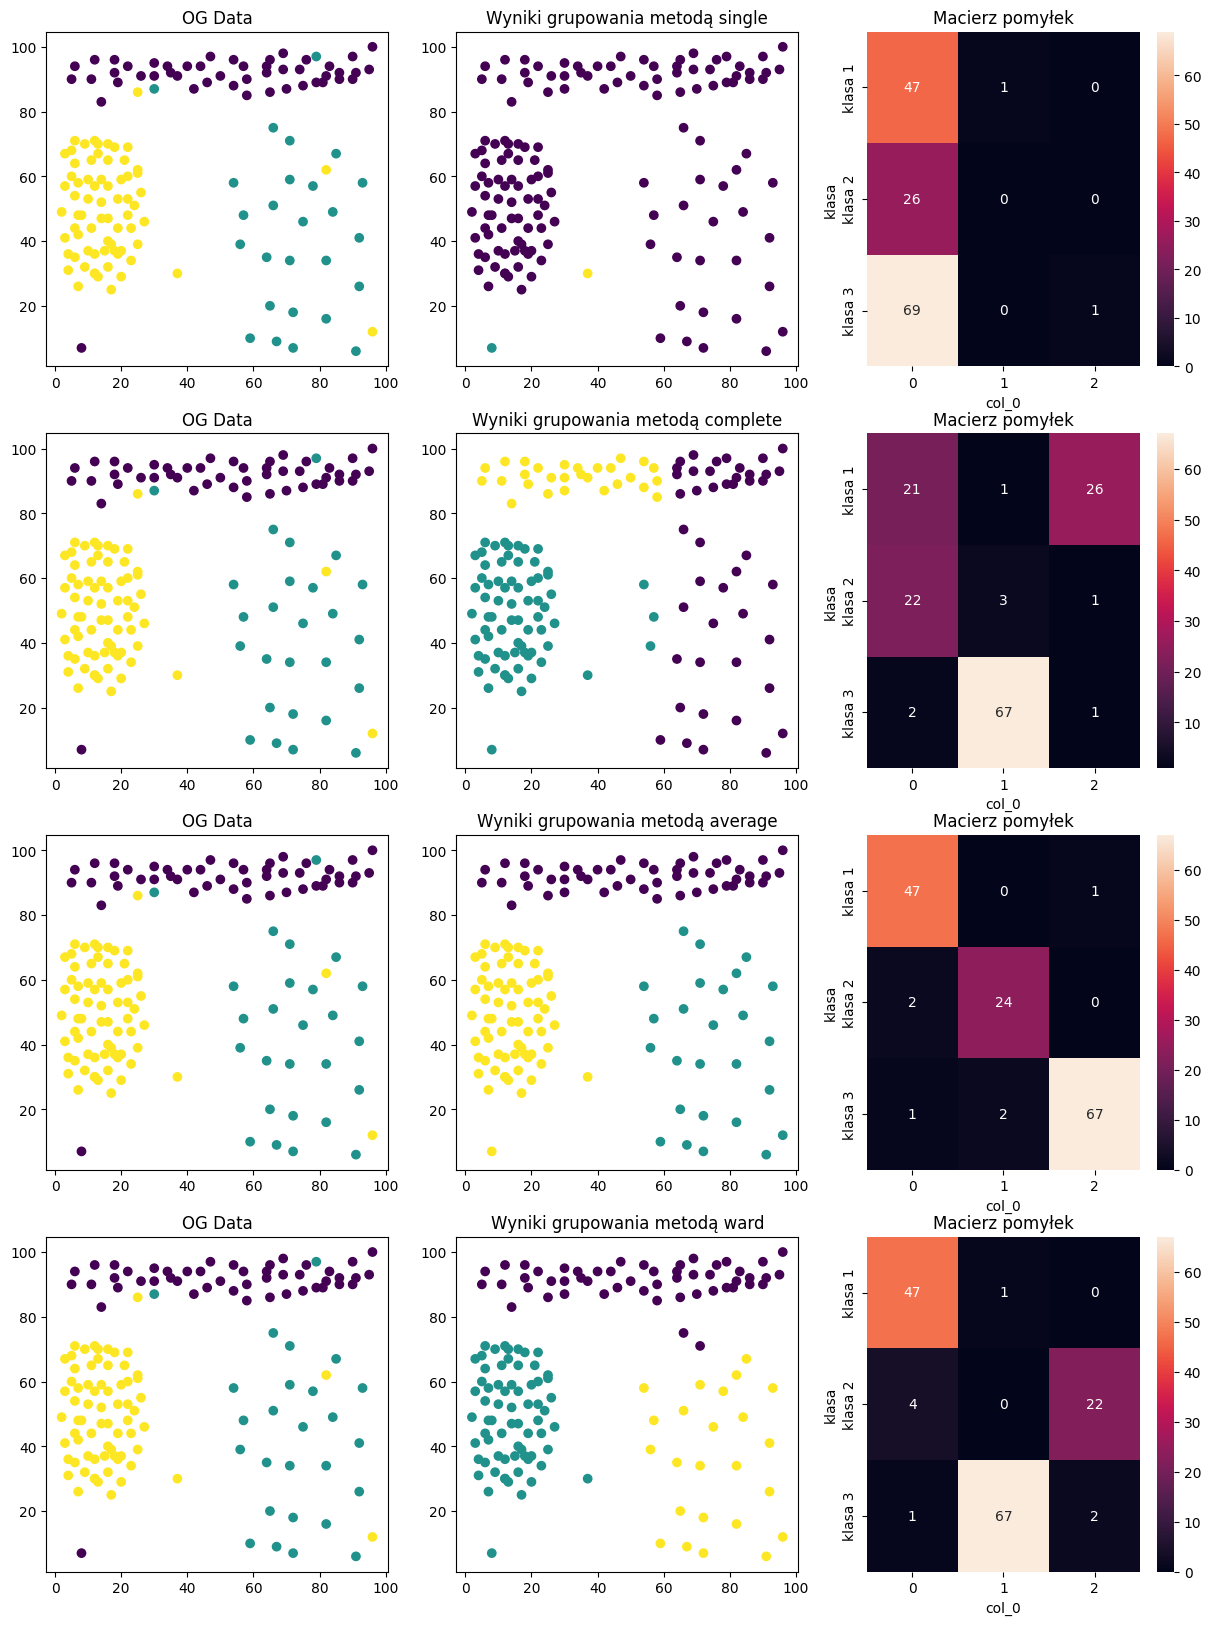

In [35]:
import seaborn as sns

plt.figure(figsize=(15, 20))
data_og, data_noclass = mk_dataframes("dane6.csv")
group_no = 3

metody = ["single", "complete", "average", "ward"]

for i in range(4):
    plt.subplot(4, 3, 3*i+1)
    plt.title("OG Data")
    plt.scatter(data_noclass.atrybut1, data_noclass.atrybut2, c = data_og.klasa.astype("category").cat.codes)

    plt.subplot(4, 3, 3*i+2)
    plt.title(f"Wyniki grupowania metodą {metody[i]}")

    model = AgglomerativeClustering(linkage=metody[i], metric="euclidean", n_clusters=group_no)
    model.fit(data_noclass)

    plt.scatter(data_noclass.atrybut1, data_noclass.atrybut2, c = model.labels_)

    plt.subplot(4, 3, 3*i+3)
    plt.title("Macierz pomyłek")

    differences = pd.crosstab(data_og.klasa, model.labels_)
    sns.heatmap(differences, annot=differences)

W powyższym przykładzie grupowanie metodą single przypisuje większość obiektów do jednej klasy. Metoda complete przyporządkowuje jedną grupę poprawnie, ale miesza obiekty z pozostałych grup. Metody ward oraz average poprawnie przyporządkowywują obiekty do ich klas.

> **Zadanie:** Zobacz, jakie wyniki będą miały dane z innych plików. Porównaj wpływ wybranych metod i metryk dla różnych danych.

Poniżej grupuję dane z pliku `dane6.csv` zapisane w zmiennej `data_og` i `data_noclass` oraz tworzę dendrogramy na 3 sposoby, przy użyciu kolejno pakietów `scipy`, `sklearn` i `plotly`, poprzedzanie importami odpowiednich pakietów

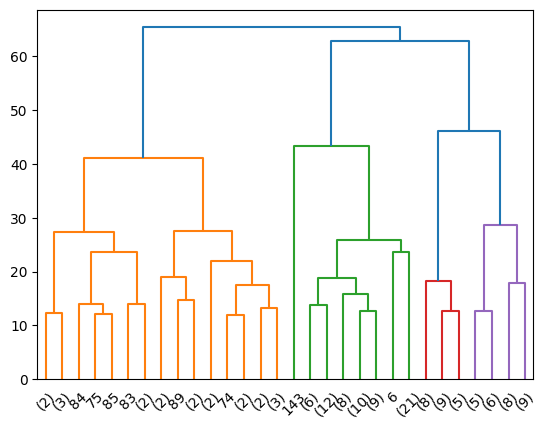

In [36]:
from scipy.cluster.hierarchy import linkage, dendrogram

linked = linkage(data_noclass, method = "average", metric = "euclidean")
dg = dendrogram(linked, truncate_mode = 'lastp')
#przypisanie dendrogramu do zmiennej jest zrobione tylko dlatego, że w przeciwnym wypadku jupyter wyświetla to, co dendrogram zwraca

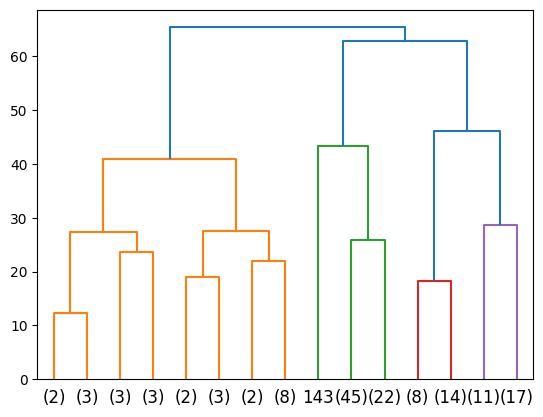

In [37]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
   counts = np.zeros(model.children_.shape[0])
   n_samples = len(model.labels_)
   for i, merge in enumerate(model.children_):
       current_count = 0
       for child_idx in merge:
           if child_idx < n_samples:
               current_count += 1
           else:
               current_count += counts[child_idx - n_samples]
       counts[i] = current_count

   linkage_matrix = np.column_stack(
       [model.children_, model.distances_, counts]
   ).astype(float)

   dendrogram(linkage_matrix, **kwargs)

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None,  metric="euclidean", linkage="average")
model = model.fit(data_noclass)

plot_dendrogram(model, truncate_mode="level", p=3)

[Source](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html)

Poniższy kod nie używa standardowych pakietów, możliwe że trzeba doinstalować pakiety `plotly` oraz `nbformat`

In [38]:
import plotly.figure_factory as ff

fig = ff.create_dendrogram(data_noclass)
fig.update_layout(width=800, height=500)
fig.show()

# 2. Grupowanie k-średnich

Metoda grupowania k średnich polega na wybraniu losowo lub przy użyciu algorytmów punktów środków klastrów (centroidów), przypisanie obiektów do centroidu w taki sposób, żeby wartość odległości od centroidu do przypisanych mu obiektów była jak najmniejsza, a odległość do innych centroidów była jak największa. powtarzamy 2 powyższe kroki, dopóki nie osiągniemy zadowalających wyników.

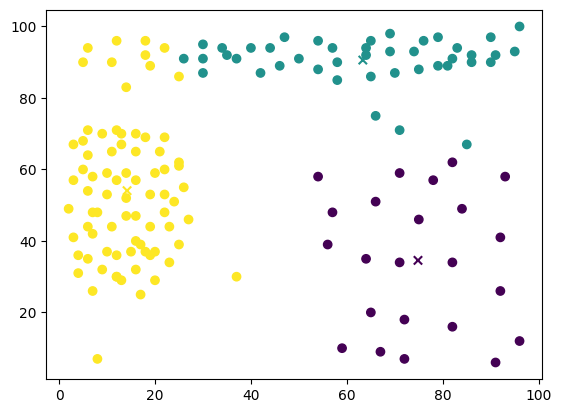

In [60]:
from sklearn.cluster import KMeans

liczba_grup = 3

model = KMeans(n_clusters = liczba_grup, random_state = 0, n_init = 10)
#random_state jest wartością używaną jako seed dla losowych początkowych centroidów
#n_init to liczba, ile razy losowe centroidy są wyznaczane, 10 to aktualna domyślna wartość, ale zostanie ona niedługo zmieniona, więc żeby sklearn nie wypisywał zażaleń, używam domyślnej wartości
model.fit(data_noclass)

plt.scatter(data_noclass.atrybut1, data_noclass.atrybut2, c = model.labels_)
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], marker = "x", c = range(liczba_grup))
#x to centroidy wyznaczone przez metodę k-średnich

Ważną informacją potrzebną metodzie k-średnich jest liczba grup. Nie jest ona zazwyczaj znana, a ich liczba nie zawsze jest tak oczywista jak dla danych z pliku `dane1.csv`. Mamy do dyspozycji 2 metody:
+ **Metoda Łokciowa** - tworzymy klastry dla rosnącej liczby klastrów a następnie wyświetlamy sumę odległości obiektów od ich klastrów
+ **Metoda sylwetki danych** - wyliczamy wartość średnią wartości sylwetki dla wszystkich obiektów, która wynosi $\frac{b(i)-a(i)}{max\{a(i),b(i)\}}$, gdzie $a(i)$ to odległość od centroidu obiektu a $b(i)$ to odległość od najbliższego, niezaklasyfikowanego centroidu.

W metodzie łokciowej szukamy punktu, dla którego wykres przestaje gwałtownie maleć, a w metodzie sylwetki szukamy punktu, który jest największy. Wartość sylwetki dla każdego punktu może być pomiędzy -1 a 1.

**Metoda łokciowa**

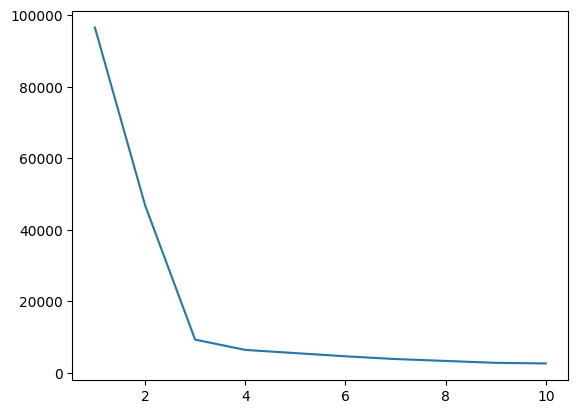

In [44]:
data_1_og, data_1_noclass = mk_dataframes("dane1.csv")

def met_lokciowa(dane, maksymalna_ilosc_centroidow):
    met_lokciowa_wartosci = []

    for k in range(1, maksymalna_ilosc_centroidow+1):
        kmeans = KMeans(n_clusters = k, n_init = 10).fit(dane)
        centroidy = kmeans.cluster_centers_
        przewidziane_centroidy = kmeans.predict(dane)
        aktualna_wartosc_metody = 0

        for i in range(len(dane)):
            aktualny_centroid = centroidy[przewidziane_centroidy[i]]
            aktualna_wartosc_metody += (dane.iloc[i, 0] - aktualny_centroid[0]) ** 2 + (dane.iloc[i, 1] - aktualny_centroid[1]) ** 2
        
        met_lokciowa_wartosci.append(aktualna_wartosc_metody)
    return met_lokciowa_wartosci

plt.figure()
plt.plot(range(1,11), met_lokciowa(data_1_noclass, 10))

W powyższym przykładzie dla danych z plike `dane1.csv` bardzo wyraźnie widać, że optymalna liczba klastrów to 3.

> **Zadanie:** Zastanów się, czy kod w powyższej funkcji zwróci odpowiednie wyniki w przypadku, jeżeli pierwszy i drugi atrybut nachodziłyby na siebie. W jaki sposób można by zmodyfikować powyższą funkcję, żeby brała ona pod uwagę wszystkie atrybuty?

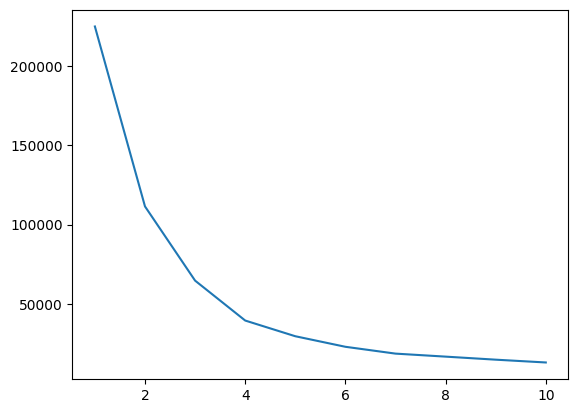

In [45]:
plt.figure()
plt.plot(range(1,11), met_lokciowa(data_noclass, 10))

W powyższym przykładzie dla danych z pliku `dane6.csv` Nie jesteśmy w stanie jednoznacznie odpowiedzieć, ile jest grup. Dlatego trzeba użyć metode Sylwetki.

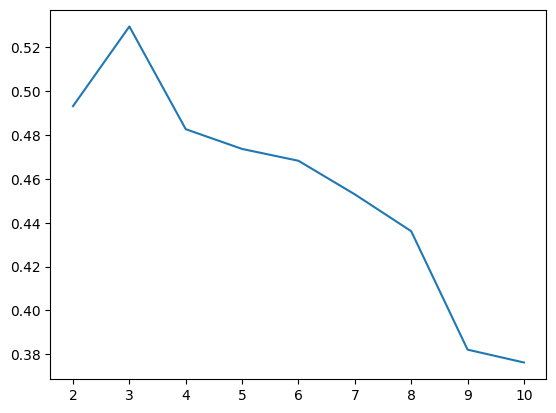

In [50]:
from sklearn.metrics import silhouette_score

def met_sylwetki(dane, maksymalna_ilosc_centroidow):
    met_sylwetki_wartosci = []

    for k in range(2, maksymalna_ilosc_centroidow+1):
        # metoda sylwetki działa na co najmniej 2 centroidach, ponieważ potrzebujemy do wyliczenia wyniku sylwetki co najmniej 2 centroidy
        kmeans = KMeans(n_clusters=k, n_init = 10).fit(dane)
        etykiety = kmeans.labels_
        met_sylwetki_wartosci.append(silhouette_score(dane, etykiety, metric = 'euclidean'))
    
    return met_sylwetki_wartosci

plt.plot(range(2,11), met_sylwetki(data_noclass, 10))

Dzięki wykresie metody sylwetkowej wyraźnie widać, że optymalna liczba grup jest równa 3

[Źródło](https://ichi.pro/pl/jak-okreslic-optymalne-k-dla-k-srednich-123716630611179)

Poniżej przedstawiona jest inna implementacja metody sylwetki. Jest ona kopią kodu z poprzednich wersji ćwiczeń. Znalezienie odpowiedniej liczby grup jest dla wykresu, na którym linia jest najbardziej w prawo.

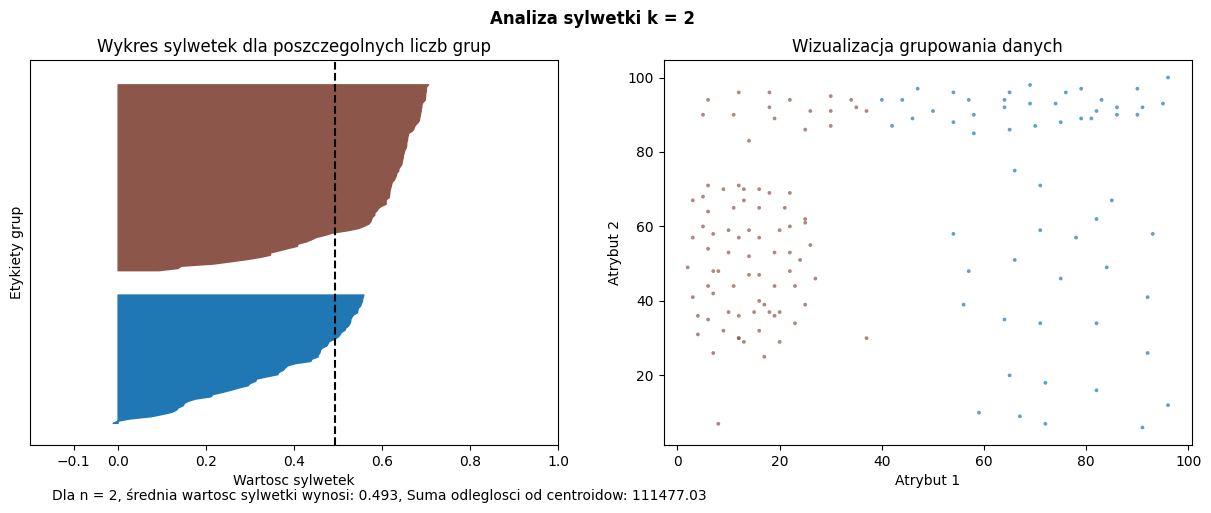

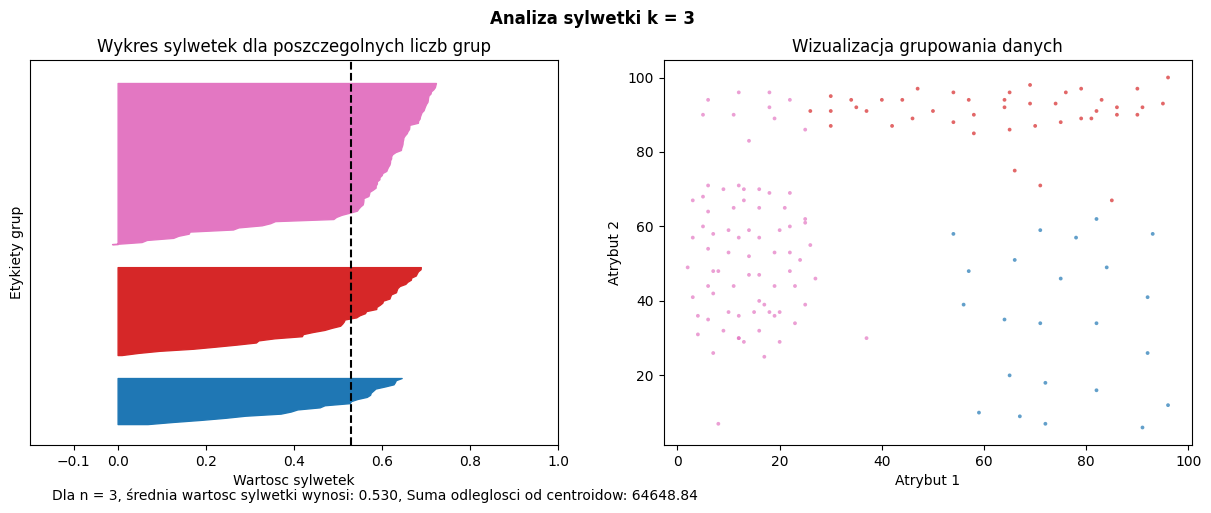

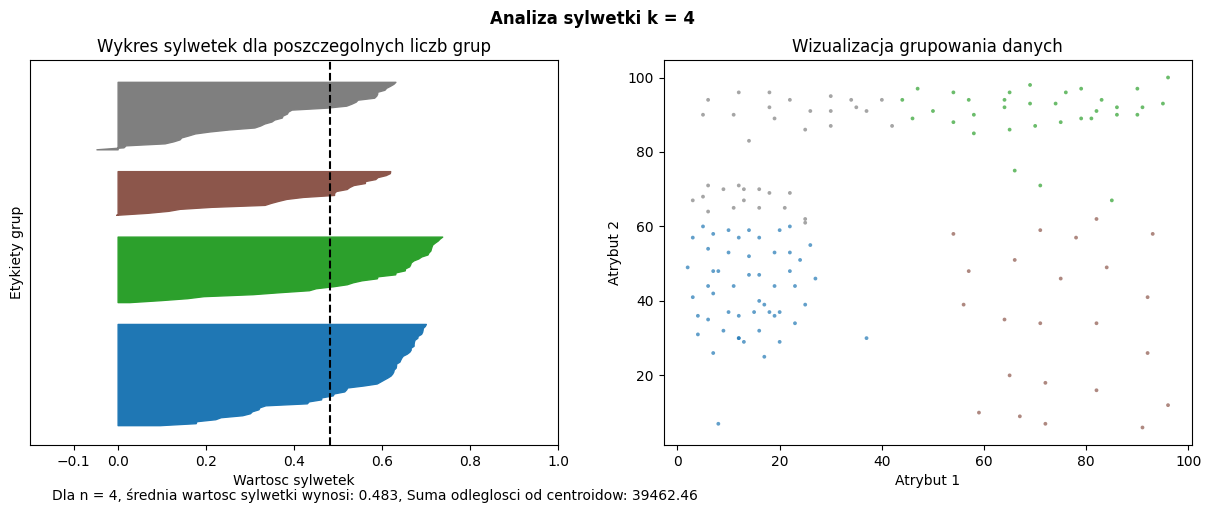

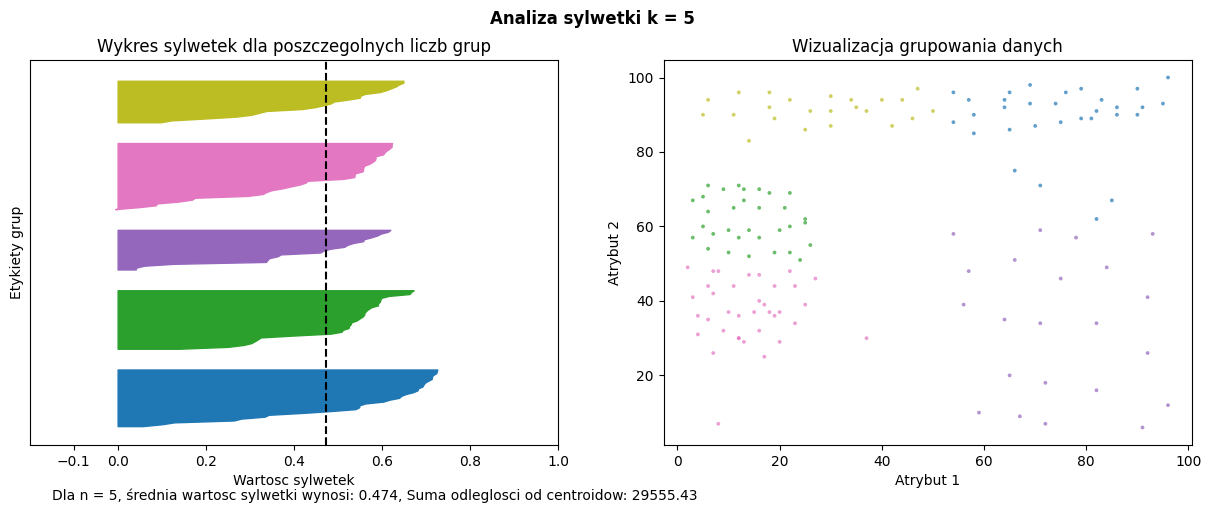

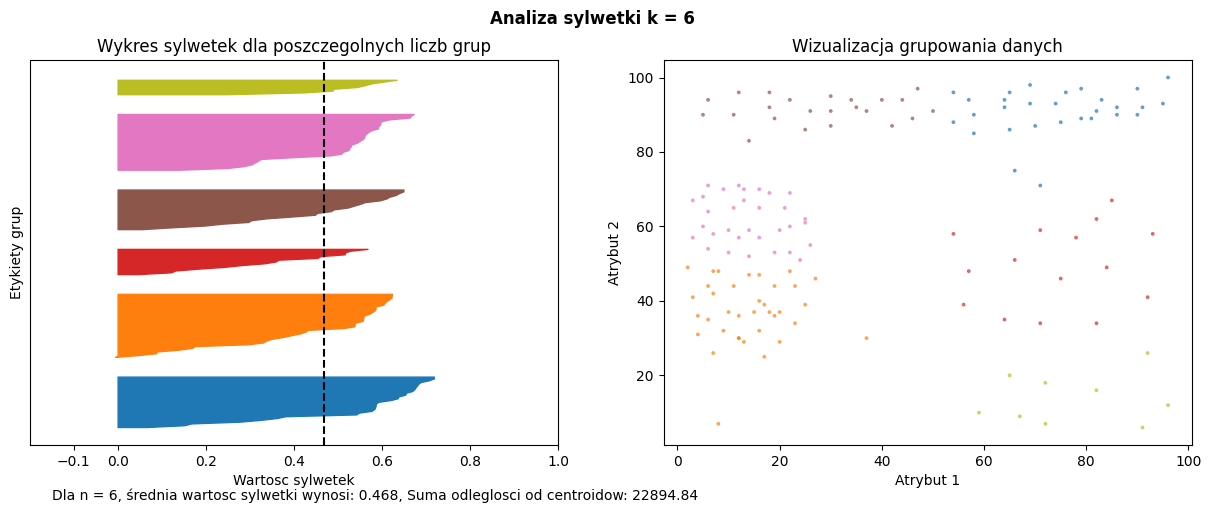

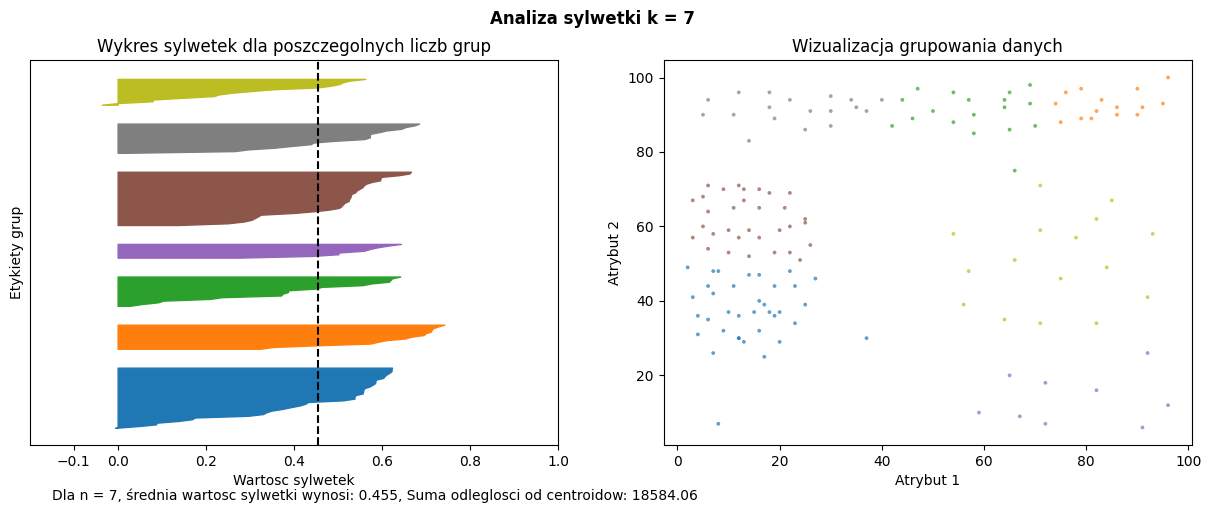

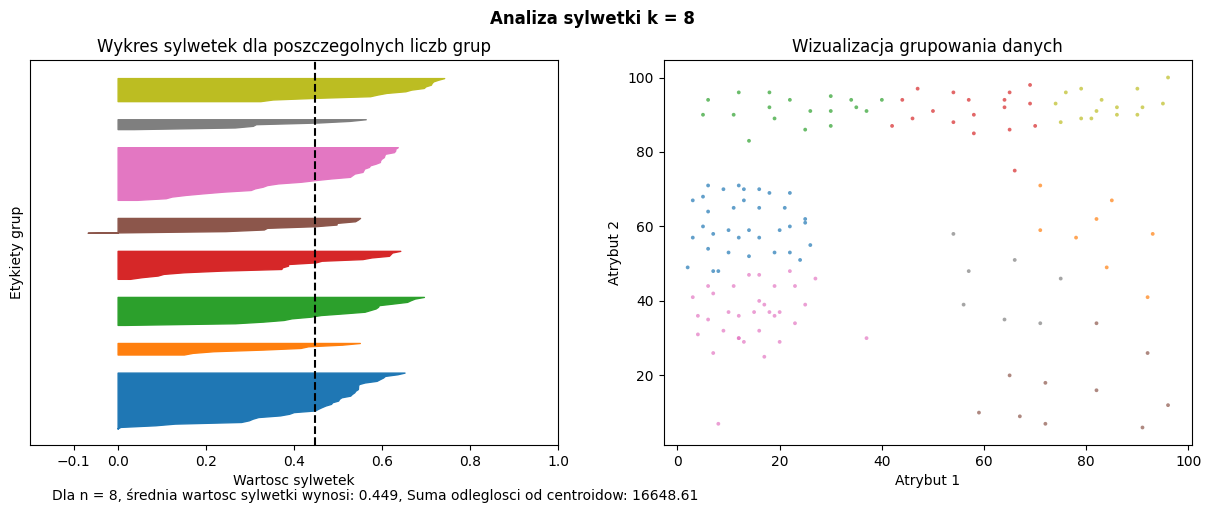

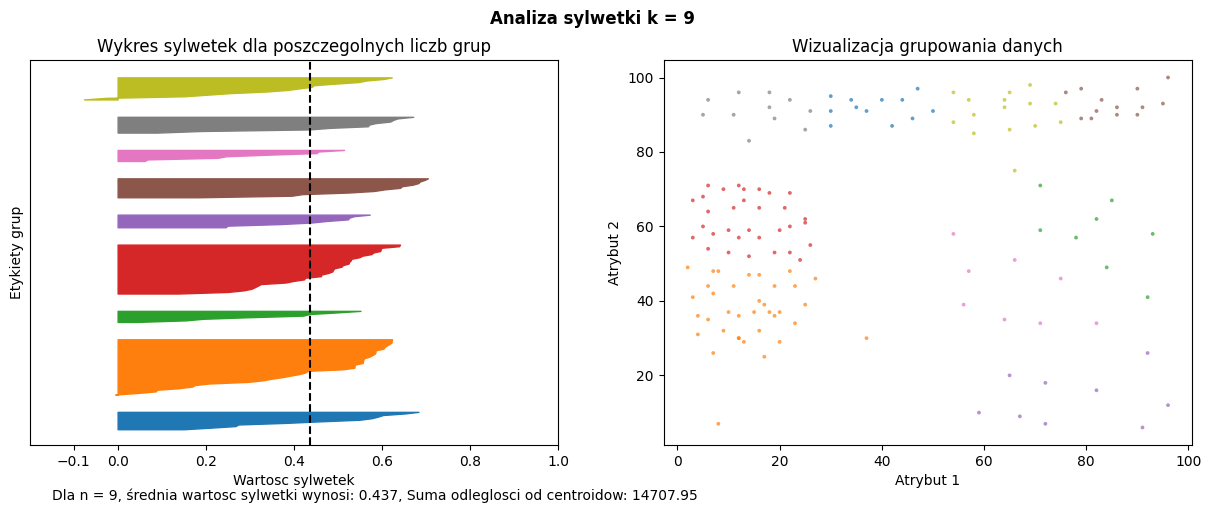

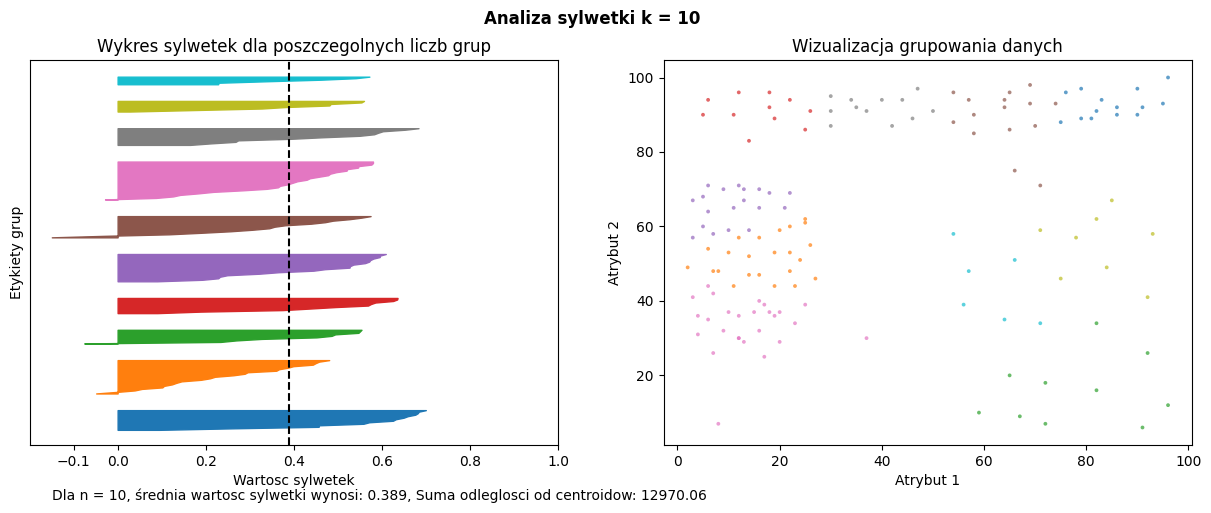

Text(0, 0.5, 'Suma odleglosci od centroidow')

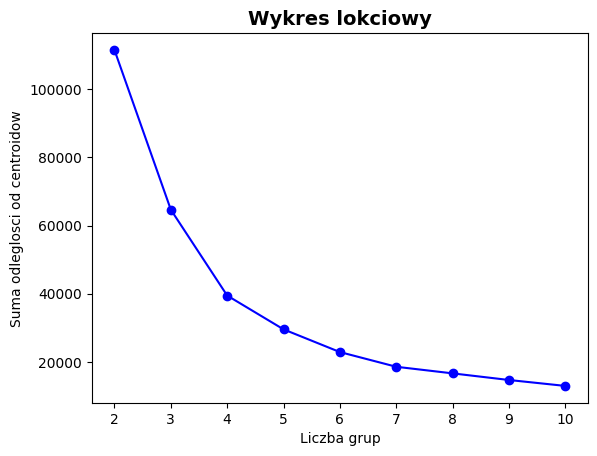

In [59]:
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

miara_jakosci = []

for ile_grup in range(2, 11) :
    # Tworzenie subplotów z jednym rzędem i 2 kolumnami
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)

    ax1.set_xlim([-0.2, 1]) # zakres zmian współczynnika sylwetki
    ax1.set_ylim([0, len(data_noclass) + (ile_grup + 1) * 10]) # organizacja wydruku
    
    kmeans = KMeans(n_clusters = ile_grup, random_state = 0, n_init = 10).fit(data_noclass)
    miara_jakosci.append(pd.Series(kmeans.inertia_))
    etykiety_grup = kmeans.fit_predict(data_noclass[['atrybut1','atrybut2']])
 
    # oblicza miary sylwetek dla każdek grupy
    sylwetka = silhouette_samples(data_noclass[['atrybut1','atrybut2']], etykiety_grup)   
    # średnia wartość sylwetki
    srednia_sylwetka = silhouette_score(data_noclass[['atrybut1','atrybut2']], etykiety_grup)
    
    pozycja_kreski = 10
    for i in range(ile_grup):
        # Zebranie wyników sylwetek do próbek należących do klastra i ich sortowanie
        sylwetka_w_grupie = sylwetka[etykiety_grup == i]
        sylwetka_w_grupie.sort()

        liczebnosc_grupy = sylwetka_w_grupie.shape[0]
        kolor = cm.tab10(float(i) / ile_grup)
        ax1.fill_betweenx(np.arange(pozycja_kreski, pozycja_kreski + liczebnosc_grupy), 0, sylwetka_w_grupie ,color = kolor)

        # Wyliczenie przesunięcia w pionie dla wykresu kolejnej grupy
        pozycja_kreski += liczebnosc_grupy + 10  # 10 dla kolejnej próbki
        
    ax1.set_title("Wykres sylwetek dla poszczegolnych liczb grup")
    ax1.set_xlabel("Wartosc sylwetek")
    ax1.set_ylabel("Etykiety grup")

    # Wyrysowanie wartości średniej sylwetki 
    ax1.axvline(x = srednia_sylwetka, color = "black", linestyle = "--")
    ax1.set_yticks([])  # Wyczyszczenie etykiety osi Y
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # Drugi wykres będzie przedstawiał klastry
    kolory = cm.tab10(etykiety_grup.astype(float) / ile_grup)
    ax2.scatter(data_noclass.atrybut1, data_noclass.atrybut2, marker = '.', s = 30, lw = 0, alpha = 0.7,c = kolory)

    ax2.set_title("Wizualizacja grupowania danych")
    ax2.set_xlabel("Atrybut 1")
    ax2.set_ylabel("Atrybut 2")

    plt.suptitle(("Analiza sylwetki k = %d" % ile_grup),  fontweight = 'bold')
    plt.figtext(0.14, 0, ("Dla n = %d, średnia wartosc sylwetki wynosi: %.3f, Suma odleglosci od centroidow: %.2f"
                 % (ile_grup, srednia_sylwetka, kmeans.inertia_ ) ))
    plt.show()
    
plt.plot(range(2,11), miara_jakosci,'bo-')
plt.title("Wykres lokciowy", fontsize = 14, fontweight = 'bold')
plt.xlabel("Liczba grup")
plt.ylabel("Suma odleglosci od centroidow")

> **Zadanie:** Przetestuj powyższe metody dla danych z pozostałych plików.

> **Zadanie:** Metoda KMeans ma argument `random_state`, który przyjmuje wartość liczbową i wpływa na wartości początkowe algorytmu. Porównej różne wartości tego argumentu dla różnych danych.

# 3. Analiza koszyka zakupowego

Analiza koszyka zakupowego polega na przypisaniu prawdopodobieństwa kupienia konkretnych przedmiotów, jeżeli w naszym koszyku znajdują się już jakieś przedmioty. Algorytmy dla takiej analizy są w pakiecie [MLxtend](http://rasbt.github.io/mlxtend/).

Zbiór danych `sklep.xlsx` zawiera koszyki zakupowe, w których znajdują się pewne przedmioty (1) lub nie (0).

In [98]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

df = pd.read_excel('sklep.xlsx',header = 1,usecols = range(1,9), index_col = 0)
print(df)
df = df.astype(bool)
# zmiana tabeli na booleany, wg. zaleceń MLxtend

      Długopis  Ołówek  Zeszyt  Papier  Linijka  Kredki  Blok
 Lp.                                                         
1            1       0       1       0        0       0     0
2            0       1       0       1        0       0     0
3            0       0       1       0        0       1     0
4            0       1       1       0        0       1     0
5            0       0       1       0        1       0     0
6            0       0       0       0        0       1     1
7            1       0       0       0        1       1     1
8            1       0       1       0        1       0     0
9            1       0       0       1        0       0     0
10           1       1       0       0        0       1     0
11           0       0       1       0        0       0     0
12           0       0       1       0        0       0     1
13           1       0       1       0        1       1     0
14           0       0       0       0        0       1     1
15      

Wybieramy częste zbiory (wg. zasady a-priori) o progu wsparcia powyżej 0.2.

In [99]:
zbiory_czeste = apriori(df, min_support=0.1, use_colnames=True)
zbiory_czeste

,support,itemsets
0,0.45,(Długopis)
1,0.25,(Ołówek)
2,0.55,(Zeszyt)
3,0.15,(Papier)
4,0.45,(Linijka)
5,0.55,(Kredki)
6,0.25,(Blok)
7,0.10,"(Ołówek, Długopis)"
8,0.30,"(Zeszyt, Długopis)"
9,0.25,"(Długopis, Linijka)"


Generowanie reguł na podstawie zbiorów częstych.

In [100]:
reguly = association_rules(zbiory_czeste, metric="lift", min_threshold=1)
reguly

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Zeszyt),(Długopis),0.55,0.45,0.30,0.545455,1.212121,0.0525,1.210000,0.388889
1,(Długopis),(Zeszyt),0.45,0.55,0.30,0.666667,1.212121,0.0525,1.350000,0.318182
2,(Długopis),(Linijka),0.45,0.45,0.25,0.555556,1.234568,0.0475,1.237500,0.345455
3,(Linijka),(Długopis),0.45,0.45,0.25,0.555556,1.234568,0.0475,1.237500,0.345455
4,(Kredki),(Długopis),0.55,0.45,0.25,0.454545,1.010101,0.0025,1.008333,0.022222
5,(Długopis),(Kredki),0.45,0.55,0.25,0.555556,1.010101,0.0025,1.012500,0.018182
6,(Ołówek),(Papier),0.25,0.15,0.10,0.400000,2.666667,0.0625,1.416667,0.833333
7,(Papier),(Ołówek),0.15,0.25,0.10,0.666667,2.666667,0.0625,2.250000,0.735294
8,(Zeszyt),(Linijka),0.55,0.45,0.25,0.454545,1.010101,0.0025,1.008333,0.022222
9,(Linijka),(Zeszyt),0.45,0.55,0.25,0.555556,1.010101,0.0025,1.012500,0.018182


Wybieramy regóły, gdzie prawdopodobieństwo mamy powyżej 80%.

In [102]:
reguly[ (reguly['confidence'] >= 0.8) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
13,(Blok),(Kredki),0.25,0.55,0.2,0.8,1.454545,0.0625,2.25,0.416667
15,"(Zeszyt, Linijka)",(Długopis),0.25,0.45,0.2,0.8,1.777778,0.0875,2.75,0.583333
16,"(Długopis, Linijka)",(Zeszyt),0.25,0.55,0.2,0.8,1.454545,0.0625,2.25,0.416667
32,"(Blok, Linijka)",(Kredki),0.10,0.55,0.1,1.0,1.818182,0.0450,inf,0.500000
37,"(Zeszyt, Kredki, Linijka)",(Długopis),0.10,0.45,0.1,1.0,2.222222,0.0550,inf,0.611111


W pierwszej kolumnie mamy wymagania, żeby przedmiot w drugiej kolumnie został kupiony z prawdopodobieństwem z szóstej kolumny.

> **Zadanie:** Poeksperymentuj z wartościami parametrów

> **Zadanie:** Wygeneruj losowy inny zestaw transakcji. Sprawdź wyniki z różnym doborem parametrów.

In [93]:
#Generacja losowego zestawu danych
from random import seed, randrange
from math import sqrt

#Można odkomentować kolejną linijkę, żeby mieć zawsze te same losowe dane
#random.seed(0)

#Możesz dodać swoje przedmioty
cols = ["Długopis", "Ołówek", "Zeszyt", "Papier", "Linijka", "Kredki", "Blok", "Klej", "Marker", "Buty", "Skarpety", "Spodnie", "Koszulka", "Bluza", "Czapka"]
#Możesz zmniejszyć albo zwiększyć liczbę obiektów
rows = 10_000

df = pd.DataFrame(columns=cols, index=range(rows)).fillna(0)

for i in range(rows):
    df.iloc[i, random.randrange(0, len(cols))] = 1

for i in range(int(0.379*df.size) - df.shape[0]//2):
    df.iloc[randrange(rows), randrange(len(cols))] = 1

df.to_csv("losowy_sklep.csv")

## Dla dociekliwych
* [Porównanie różnych rodzajów odległości międzygrupowej w grupowaniu](https://scikit-learn.org/stable/auto_examples/cluster/plot_linkage_comparison.html)
* [Grupowanie k-średnich, poradnik](https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html)
* [Grupowanie k-średnich, przypadki szczególne](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html#sphx-glr-auto-examples-cluster-plot-kmeans-assumptions-py) 
* [Market basket analysis](https://pbpython.com/market-basket-analysis.html)
* [Market basket analysis 2](https://www.kaggle.com/xvivancos/market-basket-analysis#loading-data)


---
---
Historia zmian:
* wersja pierwotna r.akad 18/19: 04.2019 (GS,MI)
* wersja r.akad 19/20: 16.04.2020 (MI)
* wersja r.akad 20/21: 20.11.2020 (MI) bez zmian
* wersja r.akad 21/22: 28.11.2020 (MI) bez zmian
* wersja r.akad 22/23: 28.01.2023 (AM)